Downloading and unarchiveing the amazon data, it is already split to train and test, we are going to use it for training and validation, we will be testingg with our own data.

In [3]:
!wget "https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz"
!tar -xvf amazon_review_polarity_csv.tgz

--2020-12-05 19:37:54--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.28.214
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.28.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘amazon_review_polarity_csv.tgz.1’

amazon_review_polar 100%[===================>] 656.45M  27.1MB/s    in 41s     

2020-12-05 19:38:36 (15.9 MB/s) - ‘amazon_review_polarity_csv.tgz.1’ saved [688339454/688339454]

amazon_review_polarity_csv/
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt
amazon_review_polarity_csv/test.csv


Prepearing the data: the firs column of the dataset is the lable: labble 2 is positive and lable 1 is negative
the second row is the subject, and the third is the full rewiev

In [2]:
import torch
import torch.nn as nn
import torch.optim

from sklearn.model_selection import train_test_split

import os
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from tqdm import tqdm

from transformers import BertTokenizer, BertForSequenceClassification

#by loading the data with the right column names we dont have to do much in terms of prepearing
train_data_amazon = pd.read_csv("amazon_review_polarity_csv/train.csv", names=("labels", "subject", "data"))
valid_data_amazon = pd.read_csv("amazon_review_polarity_csv/test.csv", names=("labels", "subject", "data"))

#we have to subtract 1 from the labels to get labels 0 and 1 instead of 1 and 2
train_data_amazon["labels"] -= 1
valid_data_amazon["labels"] -= 1

#we will only use a portion of the datasets due to time concerns
train_data = train_data_amazon.head(7200)
valid_data = valid_data_amazon.head(1000)
test_data = valid_data_amazon.tail(50) #until we have our own test data

display(train_data)

,labels,subject,data
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
7195,1,A Scary Preview of the future of American Society,"I first read this book after my mother, a seni..."
7196,1,Great Book,The author did a great job. It is a Very high ...
7197,1,Fascinating!,I started writing sci fi because of this book....
7198,1,Good book,This is definitely a well written book. It's o...


In [3]:
if not torch.cuda.is_available():
    print("WARNING. GPU is not available. Did you change your runtime to GPU?")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = 2)

_ = model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [4]:
for p in model.base_model.parameters():
    p.requires_grad = False

In [5]:
# training loop

batch_size = 512
num_epochs = 5
patience = 3
optimizer = torch.optim.Adam(model.parameters())

def training():

    metrics = defaultdict(list)

    stag = 0
    prev_loss = float('inf')
    prev_accuraccy = 0.0

    for epoch in range(num_epochs):
        start_positions = list(range(0, len(train_data), batch_size))
        np.random.shuffle(start_positions)

        train_acc = 0
        train_loss = 0
        train_len = 0
        model.train()

        #we will use the tqdm progress bare librarry to better monitor the training
        start_positions = tqdm(start_positions)
        start_positions.set_description(f'Epoch {epoch + 1}/{num_epochs} training ')

        for start in start_positions:
            batch = train_data.iloc[start:start+batch_size]
            optimizer.zero_grad()
            encoded = tokenizer(batch.data.values.tolist(), truncation=True, max_length=128, padding=True, return_tensors='pt')
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)
            labels = torch.LongTensor(batch["labels"].tolist()).to(device)

            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

            loss = outputs[0]
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            predictions = outputs[1].argmax(axis=1)
            train_acc += torch.eq(predictions, labels).sum().item()

            train_len += batch_size #we count how many data we trained on to calculate the accuraccy on the fly
            if(train_len > len(train_data)): #the last batch might be smaller so we need to correct for that to get an accurate accuraccy
                train_len = len(train_data)
            start_positions.set_postfix({"loss" : train_loss, "accuraccy" : (train_acc/train_len)}) #we update loss and accuraccy after each batch

        #print(f"valid_loss {train_loss} acc {train_acc / len(train_data)}")
        metrics['train_loss'].append(train_loss)
        metrics['train_accuracy'].append(train_acc / len(train_data))

        start_positions = list(range(0, len(valid_data), batch_size))
        valid_acc = 0
        valid_loss = 0
        valid_len = 0
        model.eval()

        #we will use the tqdm progress bare librarry to better monitor the validation
        start_positions = tqdm(start_positions)
        start_positions.set_description(f'Epoch {epoch + 1}/{num_epochs} validating ')

        for start in start_positions:
            batch = valid_data.iloc[start:start+batch_size]
            encoded = tokenizer(batch.data.values.tolist(), truncation=True, max_length=128, padding=True, return_tensors='pt')
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)
            labels = torch.LongTensor(batch["labels"].tolist()).to(device)

            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

            loss = outputs[0]
            valid_loss += loss.item()

            predictions = outputs[1].argmax(axis=1)
            valid_acc += torch.eq(predictions, labels).sum().item()

            valid_len += batch_size #we count how many data we validated on to calculate the accuraccy on the fly
            if(valid_len > len(valid_data)): #the last batch might be smaller so we need to correct for that to get an accurate accuraccy
                valid_len = len(valid_data)
            start_positions.set_postfix({"loss" : valid_loss, "accuraccy" : (valid_acc/valid_len)}) #we update loss and accuraccy after each batch
        
        #print(f"valid_loss {valid_loss} acc {valid_acc / len(valid_data)}")

        metrics['valid_loss'].append(train_loss)
        metrics['valid_accuracy'].append(valid_acc / len(valid_data))

        #check for early stopping after each epoch
        if (valid_loss >= prev_loss and valid_acc <= prev_accuraccy):
            stag += 1
        if stag > patience:
            break

        prev_loss, prev_accuraccy = valid_loss, valid_acc

    return metrics

In [6]:
# evaluation
def evaluation():
    start_positions = list(range(0, len(test_data), batch_size))
    test_acc = 0
    test_loss = 0
    test_len = 0
    model.eval()
    
    #we will use the tqdm progress bare librarry to better monitor the testing
    start_positions = tqdm(start_positions)
    start_positions.set_description(f'Testing ')

    for start in start_positions:
        batch = test_data.iloc[start:start+batch_size]
        encoded = tokenizer(batch.data.values.tolist(), truncation=True, max_length=128, padding=True, return_tensors='pt')
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)
        labels = torch.LongTensor(batch["labels"].tolist()).to(device)

        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

        loss = outputs[0]
        test_loss += loss.item()

        predictions = outputs[1].argmax(axis=1)
        test_acc += torch.eq(predictions, labels).sum().item()

        test_len += batch_size #we count how many data we validated on to calculate the accuraccy on the fly
        if(test_len > len(test_data)): #the last batch might be smaller so we need to correct for that to get an accurate accuraccy
            test_len = len(test_data)
        start_positions.set_postfix({"loss" : test_loss, "accuraccy" : (test_acc/test_len)}) #we update loss and accuraccy after each batch

    #print(f"test_loss {test_loss} acc {test_acc / len(test_data)}")
    return [test_loss, test_acc / len(test_data)]

In [7]:
metrics = training()
testmetrics = evaluation()

Testing : 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, loss=0.642, accuraccy=0.72]


<AxesSubplot:>

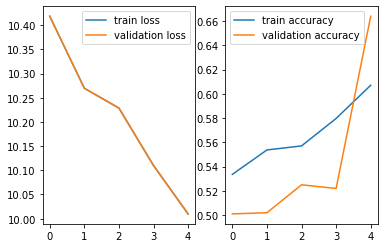

In [8]:
fig, ax = plt.subplots(1, 2)

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='train loss')
sns.lineplot(data=metrics['valid_loss'], ax=ax[0], label='validation loss')

sns.lineplot(data=metrics['train_accuracy'], ax=ax[1], label='train accuracy')
sns.lineplot(data=metrics['valid_accuracy'], ax=ax[1], label='validation accuracy')

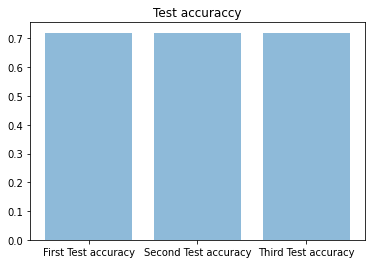

In [9]:
objects = ('First Test accuracy', 'Second Test accuracy', 'Third Test accuracy')
y_pos = np.arange(len(objects))
performance = [testmetrics[1], testmetrics[1], testmetrics[1]]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Test accuraccy')

plt.show()